In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# Computer Vision / Data imports
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Analysis & Metrics imports
from sklearn.metrics import confusion_matrix, classification_report

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Utility imports
import numpy as np
import time

In [ ]:
# Set location of data sources
train_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train' # Sets the location of the training data
val_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/val' # Sets the location of the validation data
test_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test' # Sets the location of the testing data

In [ ]:
# The model was trained using google colab. If you have access to colab GPU's it is suggested you use the below code to help speed up training. 
# If not but have an Nvidea GPU. CUDA can be installed and used to speed up the run. 
# Otherwise this code is not nessecary. 
def setup_colab():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available(): 
        torch.backends.cudnn.benchmark = True # Enable cuDNN auto-tuner to find fastest convolution algorithms
        torch.backends.cuda.matmul.allow_tf32 = True # Enable TensorFloat-32 for potential speedup
        torch.backends.cudnn.allow_tf32 = True
    return device

In [ ]:
# Define transforms for ResNet
# The values can be changed/tuned to try improve results
# Data augmentation and normalization for training
# These transformations help prevent overfitting by creating variations of the training images
# The values used for normalization are the standard ImageNet values which work well with ResNet
transform_train = transforms.Compose([
    transforms.Resize(256),  # Resize image to 256x256
    transforms.RandomCrop(224),  # Randomly crop to 224x224 for training
    transforms.RandomHorizontalFlip(),  # Randomly flip image horizontally
    transforms.RandomRotation(15),  # Randomly rotate image up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust image colors
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet values
])

# Simpler transformations for validation
transform_eval = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),  # Center crop to 224x224 for consistent evaluation
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [ ]:
# Implementation of ResNet18 architecture
# This implementation follows the original ResNet paper structure
# ResNet uses skip connections to help with the vanishing gradient problem
# The model consists of multiple BasicBlocks which contain the skip connections

class BasicBlock(nn.Module):
   expansion = 1  # Used to determine the depth of the bottleneck

   def __init__(self, in_channels, out_channels, stride=1):
       super(BasicBlock, self).__init__()
       # First convolution layer with optional stride for downsampling
       self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                             stride=stride, padding=1, bias=False)
       self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize after first convolution
       self.relu = nn.ReLU(inplace=True)  # Activation function
       # Second convolution layer always with stride 1
       self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                             stride=1, padding=1, bias=False)
       self.bn2 = nn.BatchNorm2d(out_channels)  # Normalize after second convolution

       # Skip connection path
       self.shortcut = nn.Sequential()
       # If dimensions change, we need to adjust shortcut path
       if stride != 1 or in_channels != out_channels:
           self.shortcut = nn.Sequential(
               nn.Conv2d(in_channels, out_channels, kernel_size=1,
                        stride=stride, bias=False),
               nn.BatchNorm2d(out_channels)
           )

   def forward(self, x):
       identity = x  # Save input for skip connection

       # Main path through the block
       out = self.conv1(x)
       out = self.bn1(out)
       out = self.relu(out)

       out = self.conv2(out)
       out = self.bn2(out)

       # Add skip connection and apply ReLU
       out += self.shortcut(identity)
       out = self.relu(out)

       return out

class ResNet18(nn.Module):
   def __init__(self, num_classes):
       super(ResNet18, self).__init__()
       self.in_channels = 64

       # Initial convolution layer
       self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
       self.bn1 = nn.BatchNorm2d(64)
       self.relu = nn.ReLU(inplace=True)
       self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

       # Four layer groups of BasicBlocks
       self.layer1 = self.make_layer(64, 2)  # 2 blocks of 64 channels
       self.layer2 = self.make_layer(128, 2, stride=2)  # 2 blocks of 128 channels
       self.layer3 = self.make_layer(256, 2, stride=2)  # 2 blocks of 256 channels
       self.layer4 = self.make_layer(512, 2, stride=2)  # 2 blocks of 512 channels

       # Final layers for classification
       self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
       self.fc = nn.Linear(512, num_classes)  # Final classification layer

       # Weight initialization for better training
       for m in self.modules():
           if isinstance(m, nn.Conv2d):
               nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
           elif isinstance(m, nn.BatchNorm2d):
               nn.init.constant_(m.weight, 1)
               nn.init.constant_(m.bias, 0)

   def make_layer(self, out_channels, blocks, stride=1):
       # Helper function to create groups of BasicBlocks
       layers = []
       layers.append(BasicBlock(self.in_channels, out_channels, stride))
       self.in_channels = out_channels
       for _ in range(1, blocks):
           layers.append(BasicBlock(out_channels, out_channels))
       return nn.Sequential(*layers)

   def forward(self, x):
       # Initial convolution and pooling
       x = self.conv1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.maxpool(x)

       # Pass through the four layer groups
       x = self.layer1(x)
       x = self.layer2(x)
       x = self.layer3(x)
       x = self.layer4(x)

       # Final pooling and classification
       x = self.avgpool(x)
       x = torch.flatten(x, 1)
       x = self.fc(x)
       return x

In [ ]:
# Training function for ResNet18 model
# The function sets up data loaders, optimizers, and trains the model with validation
# Uses mixed precision training for better GPU memory usage and faster training
# Implements early stopping by saving the best model based on validation accuracy
# IMPORTANT : Please read this section carefully. If you aren't using CUDA modifications to the code need to be made. 
def train_resnet18():
   device = setup_colab()  # Set up GPU if available
   scaler = GradScaler()  # For mixed precision training

   # Load and prepare datasets with the defined transformations
   train_dataset = ImageFolder(train_loc, transform=transform_train)
   val_dataset = ImageFolder(val_loc, transform=transform_eval)
   test_dataset = ImageFolder(test_loc, transform=transform_eval)

   # Create data loaders with appropriate batch sizes and workers
   train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                           num_workers=4, pin_memory=True)  # Larger batch size for training
   val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                         num_workers=2, pin_memory=True)  # Smaller batch size for validation
   test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

   # Initialize model, loss function, optimizer and learning rate scheduler
   model = ResNet18(num_classes=len(train_dataset.classes)).to(device)
   criterion = nn.CrossEntropyLoss()  # Standard loss for classification
   optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)  # SGD with momentum
   scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Learning rate decay

   # Training parameters and tracking variables
   num_epochs = 50
   best_val_acc = 0.0
   history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}

   print("Starting training...")
   for epoch in range(num_epochs):
       epoch_start = time.time()
       model.train()
       running_loss = 0.0

       # Monitor GPU usage
       # REMOVE IF NOT IN USE
       from IPython.display import clear_output
       !nvidia-smi 
       clear_output(wait=True)

       # Training loop
       for i, (images, labels) in enumerate(train_loader):
           images, labels = images.to(device), labels.to(device)

           optimizer.zero_grad()  # Clear gradients

           # Forward pass with mixed precision
           with autocast():
               outputs = model(images)
               loss = criterion(outputs, labels)

           # Backward pass with gradient scaling
           scaler.scale(loss).backward()
           scaler.step(optimizer)
           scaler.update()

           running_loss += loss.item()

           # Print training progress
           if (i + 1) % 10 == 0:
               print(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Step [{i+1}/{len(train_loader)}], '
                     f'Loss: {loss.item():.4f}')

           # Clear GPU cache periodically
           # REMOVE IF NOT IN USE
           if i % 50 == 0:
               torch.cuda.empty_cache()

       # Validation phase
       model.eval()
       val_loss = 0.0
       correct = 0
       total = 0

       # Compute validation metrics
       with torch.no_grad():
           for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               with autocast():
                   outputs = model(images)
                   loss = criterion(outputs, labels)

               val_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()

       # Calculate epoch metrics
       avg_train_loss = running_loss / len(train_loader)
       avg_val_loss = val_loss / len(val_loader)
       val_accuracy = 100 * correct / total
       epoch_time = time.time() - epoch_start

       # Update history
       history['train_loss'].append(avg_train_loss)
       history['val_loss'].append(avg_val_loss)
       history['val_acc'].append(val_accuracy)
       history['epoch_times'].append(epoch_time)

       # Print epoch results
       print(f'Epoch [{epoch+1}/{num_epochs}]:')
       print(f'Training Loss: {avg_train_loss:.4f}')
       print(f'Validation Loss: {avg_val_loss:.4f}')
       print(f'Validation Accuracy: {val_accuracy:.2f}%')
       print(f'Epoch Time: {epoch_time:.2f} seconds')

       # Save best model
       if val_accuracy > best_val_acc:
           best_val_acc = val_accuracy
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'best_val_acc': best_val_acc,
           }, 'best_resnet18.pth')

       scheduler.step()  # Update learning rate

   return model, history, best_val_acc

In [7]:
def plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy):
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create figure
    plt.figure(figsize=(20, 8))

    # Plot confusion matrix
    plt.subplot(121)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot class accuracies
    plt.subplot(122)
    class_accuracy = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Create bar plot
    bars = plt.bar(range(len(class_names)), class_accuracy)

    # Add percentage labels on top of bars
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.title('Per-Class Accuracy')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 100)

    plt.tight_layout()
    return plt.gcf()

In [ ]:
# Function to test trained model performance
# Creates confusion matrix and classification report
# Outputs overall model accuracy and per-class metrics
def test_model(model_path, test_loc, model_name):
    device = setup_colab()

    # Load the model with best validation accuracy
    model = ResNet18(num_classes=len(ImageFolder(test_loc).classes)).to(device)
    checkpoint = torch.load(model_path) # Load saved model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Testing transformations - matches validation transforms
    transform_eval = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load test dataset
    test_dataset = ImageFolder(test_loc, transform=transform_eval)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                           num_workers=2, pin_memory=True)

    # Lists to store predictions and actual labels
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    # Run model on test data
    with torch.no_grad():
        with autocast():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Get class names
    class_names = test_dataset.classes

    # Create visualization
    fig = plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy)

    # Get classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(report)

    return accuracy, confusion_matrix(all_labels, all_predictions), report

Epoch [50/50], Step [10/329], Loss: 0.0173
Epoch [50/50], Step [20/329], Loss: 0.0626
Epoch [50/50], Step [30/329], Loss: 0.0961
Epoch [50/50], Step [40/329], Loss: 0.0594
Epoch [50/50], Step [50/329], Loss: 0.1285
Epoch [50/50], Step [60/329], Loss: 0.1047
Epoch [50/50], Step [70/329], Loss: 0.1410
Epoch [50/50], Step [80/329], Loss: 0.0599
Epoch [50/50], Step [90/329], Loss: 0.0486
Epoch [50/50], Step [100/329], Loss: 0.1008
Epoch [50/50], Step [110/329], Loss: 0.0552
Epoch [50/50], Step [120/329], Loss: 0.1017
Epoch [50/50], Step [130/329], Loss: 0.0989
Epoch [50/50], Step [140/329], Loss: 0.0437
Epoch [50/50], Step [150/329], Loss: 0.0550
Epoch [50/50], Step [160/329], Loss: 0.0841
Epoch [50/50], Step [170/329], Loss: 0.0556
Epoch [50/50], Step [180/329], Loss: 0.0493
Epoch [50/50], Step [190/329], Loss: 0.1047
Epoch [50/50], Step [200/329], Loss: 0.0572
Epoch [50/50], Step [210/329], Loss: 0.0567
Epoch [50/50], Step [220/329], Loss: 0.0576
Epoch [50/50], Step [230/329], Loss: 0.06

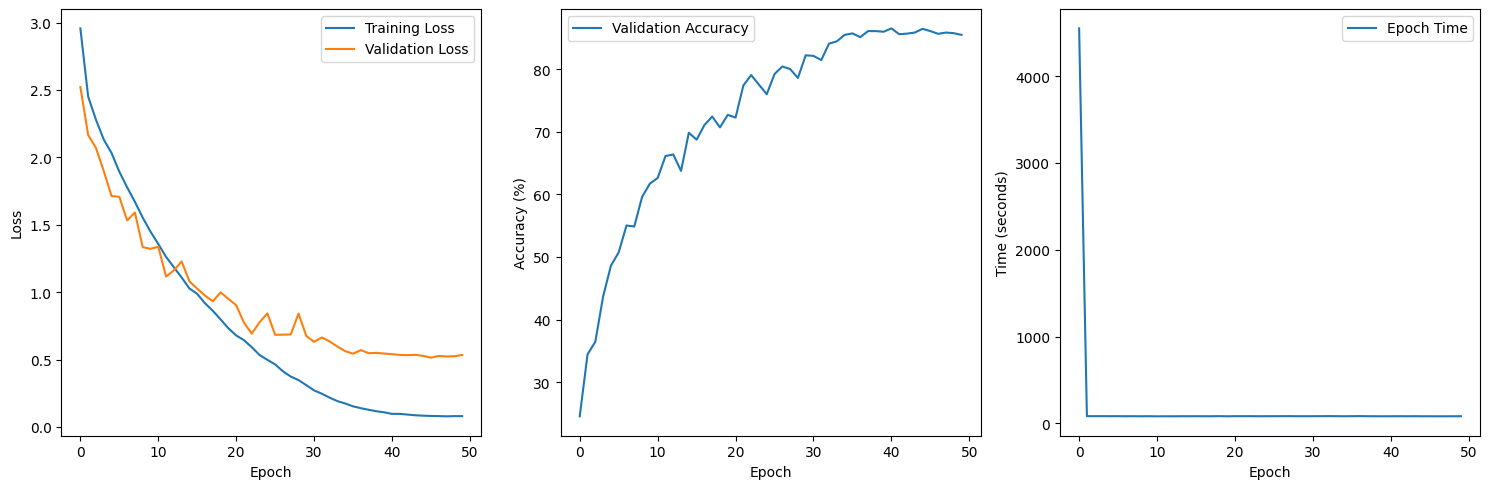

Best Validation Accuracy: 86.49%


In [ ]:
# Main execution block
# Trains the ResNet18 model and visualizes the training metrics
# Creates three plots: loss curves, accuracy progression, and training time per epoch
if __name__ == '__main__':
    model, history, best_acc = train_resnet18()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['epoch_times'], label='Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Best Validation Accuracy: {best_acc:.2f}%')


Testing the best model...
Cuda available


<ipython-input-8-d1a6236fda0f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
<ipython-input-8-d1a6236fda0f>:29: FutureWarning: `torch.


Test Accuracy: 85.37%

Classification Report:
               precision    recall  f1-score   support

     aloevera       0.88      0.89      0.89       200
       banana       0.89      0.64      0.74       200
      bilimbi       0.92      0.92      0.92       200
   cantaloupe       0.47      0.92      0.62       200
      cassava       0.73      0.88      0.80       200
      coconut       0.94      0.59      0.72       200
         corn       0.85      0.94      0.89       200
     cucumber       0.89      0.95      0.92       200
      curcuma       0.84      0.87      0.86       200
     eggplant       0.89      0.93      0.91       200
     galangal       0.84      0.94      0.89       200
       ginger       0.76      0.82      0.79       200
        guava       0.92      0.92      0.92       200
         kale       0.94      0.88      0.90       200
    longbeans       0.90      0.99      0.94       200
        mango       0.81      0.79      0.80       200
        melon    

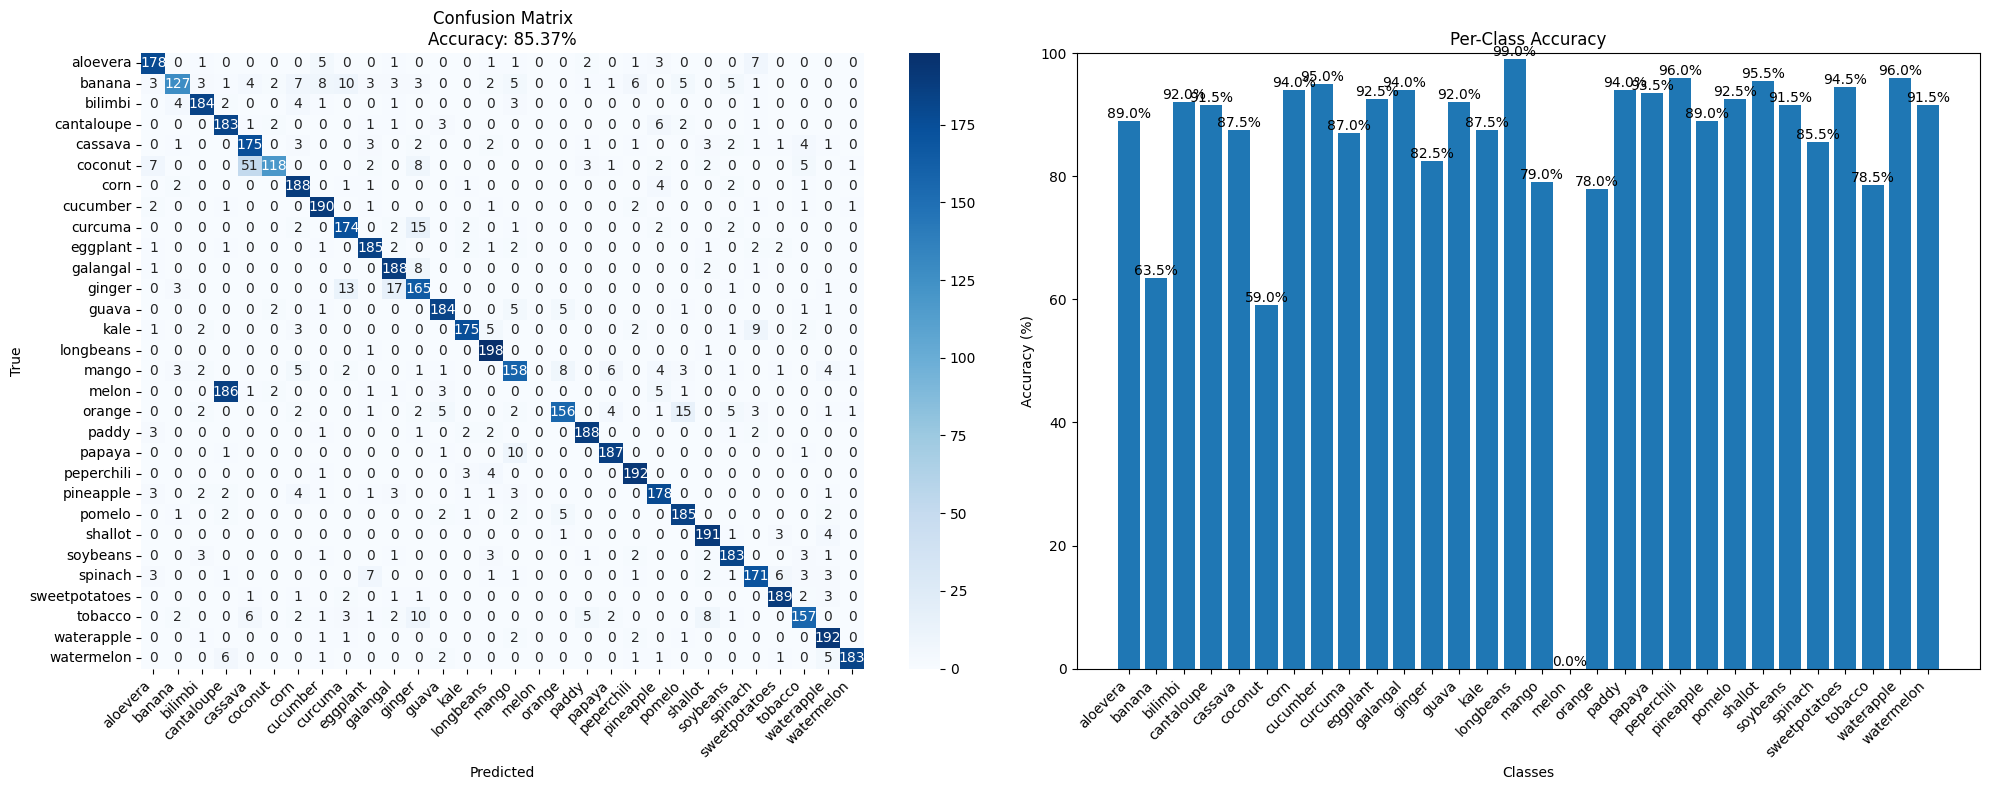

In [ ]:
# Test best model on test dataset
# Load the saved model from Google Drive and evaluate its performance
# IMPORTANT: Please update model path
print("\nTesting the best model...")
model_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_resnet18.pth' # UPDATE
accuracy, confusion_mat, report = test_model(model_path, test_loc, ResNet18)